# Comparison between TDC vs Semi-Gradient TD with linear function approximation

Here I compared RMBPBE for TD with gradient correction and semi-gradient TD(0) with linear function approximation. 

I use classical Mountain Car environment. Aim is to get an under powered car to the top of a hill (top = 0.5 position). The car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

Observation for this domain is car's position and it's velocity. Car's position can be between -1.2 and 0.5 with max velocity 0.07 in either direction. A reward of -1 is received for everytime step. Episode starts with a random position from -0.6 to -0.4 and no velocity. The goal state is absorbing with no negitive rewards.

I use linear approximation for V as $\phi.\theta$ where $\phi$ represents features corresponding to <postion,velocity> pair. Features are obtained from tilecoding.

In [19]:
import numpy as np
from utils.TileCoding import *
from utils.utils import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [20]:
# all possible actions
ACTION_REVERSE = -1
ACTION_ZERO = 0
ACTION_FORWARD = 1
# order is important
ACTIONS = [ACTION_REVERSE, ACTION_ZERO, ACTION_FORWARD]

# bound for position and velocity
POSITION_MIN = -1.2
POSITION_MAX = 0.5
VELOCITY_MIN = -0.07
VELOCITY_MAX = 0.07

# use optimistic initial value, so it's ok to set epsilon to 0
EPSILON = 0
MAX_EPISODES = 500
Max_Steps = 500

In [21]:
# take an @action at @position and @velocity
# @return: new position, new velocity
def takeAction(position, velocity, action):
    newVelocity = velocity + 0.001 * action - 0.0025 * np.cos(3 * position)
    newVelocity = min(max(VELOCITY_MIN, newVelocity), VELOCITY_MAX)
    newPosition = position + newVelocity
    newPosition = min(max(POSITION_MIN, newPosition), POSITION_MAX)
    if newPosition == POSITION_MIN:
        newVelocity = 0.0
    return newPosition, newVelocity

In [22]:
class ValueFunction:
    def __init__(self, stepSize, numOfTilings=8, maxSize=2048):
        self.maxSize = maxSize
        self.numOfTilings = numOfTilings

        # divide step size equally to each tiling
        self.stepSize = stepSize / numOfTilings

        self.hashTable = IHT(maxSize)

        # weight for each tile
        self.weights = np.zeros(maxSize)

        # position and velocity needs scaling to satisfy the tile software
        self.positionScale = self.numOfTilings / (POSITION_MAX - POSITION_MIN)
        self.velocityScale = self.numOfTilings / (VELOCITY_MAX - VELOCITY_MIN)

    # get indices of active tiles for given state and action
    def getActiveTiles(self, position, velocity):
        # I think positionScale * (position - position_min) would be a good normalization.
        # However positionScale * position_min is a constant, so it's ok to ignore it.
        activeTiles = tiles(self.hashTable, self.numOfTilings,
                            [self.positionScale * position, self.velocityScale * velocity],
                            [])
        f = np.zeros(self.maxSize)
        f[activeTiles] = 1
        return f

    # estimate the value of given state and action
    def value(self, features):
        return np.dot(self.weights, features)

    # learn with given state, action and target
    def update(self, gradient):
        self.weights += self.stepSize * gradient
        return np.linalg.norm(self.stepSize*gradient)

In [23]:
# get action at @position and @velocity based on epsilon greedy policy and @valueFunction
def getAction(position, velocity, valueFunction):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    values = []
    for action in ACTIONS:
        p,v = takeAction(position, velocity, action)
        f = valueFunction.getActiveTiles(p,v)
        values.append(valueFunction.value(f))
    return argmax(values) - 1

## Semi-gradient TD


$ \theta_{k+1} \gets \theta_{k} + \alpha [R + \gamma \hat{v}_{\theta_k}(S^{'}) - \hat{v}_{\theta_{k}}(S)]\phi $

In [24]:
#define Semi-gradient TD
def SemigradientTD(V, RMSPBEs):
    # start at a random position around the bottom of the valley
    pos = np.random.uniform(-0.6, -0.4)
    # initial velocity is 0
    vel = 0.0
    phi = V.getActiveTiles(pos, vel)
    gamma = 0.8
    reward = -1.
    RMSPBE = []
    ep = 0
    while True:
        action = getAction(pos, vel, V)
        pos_, vel_ = takeAction(pos, vel, action)
        if pos_==POSITION_MAX:
            reward=0
        phi_ = V.getActiveTiles(pos_, vel_)
        delta = reward + gamma * V.value(phi_) - V.value(phi)
        gradient = delta * phi
        V.update(gradient)
        p = np.matrix(phi_)
        value = np.sqrt(np.dot(np.dot(delta*p, p.T),np.dot(p,delta*p.T)))
        RMSPBE.append(value.item((0, 0)))
        ep += 1
        pos = pos_
        vel = vel_
        phi = phi_
        if ep > 500:
            break
    RMSPBEs.append(np.asarray(RMSPBE))

## TD with gradient correction


$ \delta_{k} = r + \gamma \theta_{k}^{T}\phi^{'} - \theta_{k}^{T}\phi$

$ \omega_{k+1} \gets \omega_{k} + \beta (\delta_{k} - \phi_{k}^{T} \omega_{k}) \phi_{k}$

$ \theta_{k+1} \gets \theta_{k} + \alpha \delta_{k}\phi_{k} -\alpha \gamma \phi_{k}^{'}(\phi_{k}^T \omega_{k}) $

In [25]:
def TDC(V, RMSPBEs, alpha):
    # start at a random position around the bottom of the valley
    pos = np.random.uniform(-0.6, -0.4)
    # initial velocity is 0
    vel = 0.0
    phi = V.getActiveTiles(pos, vel)
    gamma = 0.8
    reward = -1.
    RMSPBE = []
    episode = 0
    W = np.random.rand(2048)
    while True:
        action = getAction(pos, vel, V)
        pos_, vel_ = takeAction(pos, vel, action)
        if pos_==POSITION_MAX:
            reward=0
        phi_ = V.getActiveTiles(pos_, vel_)
        delta = reward + gamma * V.value(phi_) - V.value(phi)
        gradient = delta * phi - gamma * phi_ * np.dot(phi, W)
        W += alpha * (delta - np.dot(phi, W)) * phi
        V.update(gradient)
        p = np.matrix(phi_)
        value = np.sqrt(np.dot(np.dot(delta*p,p.T), np.dot(p,delta*p.T)))
        RMSPBE.append(value.item((0, 0)))
        episode += 1
        pos = pos_
        vel = vel_
        phi = phi_
        if episode > 500:
            break
    RMSPBEs.append(np.asarray(RMSPBE))

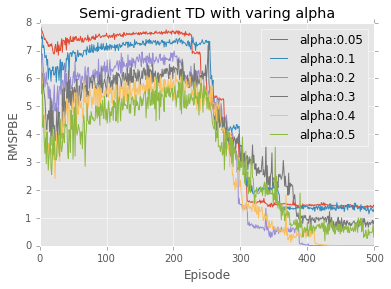

In [26]:
RUN = 10
numOfTilings = 8
alphas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

for a in alphas:
    SemigradientTD_err = []
    for i in range(RUN):
        v = ValueFunction(a, numOfTilings)
        SemigradientTD(v, SemigradientTD_err)
    plt.plot(np.mean(SemigradientTD_err, axis=0), label = 'alpha:'+str(a))
plt.xlabel('Episode')
plt.ylabel('RMSPBE')
plt.legend(loc='best')
plt.title('Semi-gradient TD with varing alpha')
plt.show()

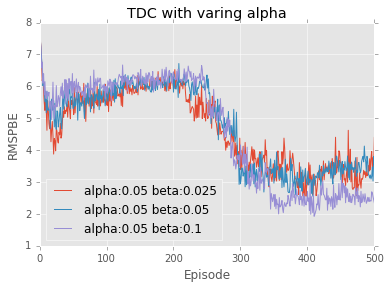

In [27]:
RUN = 10
numOfTilings = 8
alphas = [0.05]#, 0.1, 0.3, 0.5]
etas = [0.5, 1, 2]

for a in alphas:
    for n in etas:
        beta = n*a
        TDC_err = []
        for i in range(RUN):
            v = ValueFunction(a, numOfTilings)
            TDC(v, TDC_err, beta/numOfTilings)
        plt.plot(np.mean(TDC_err, axis=0), label = 'alpha:'+str(a)+" beta:"+str(beta))
plt.xlabel('Episode')
plt.ylabel('RMSPBE')
plt.legend(loc='best')
plt.title('TDC with varing alpha')
plt.show()

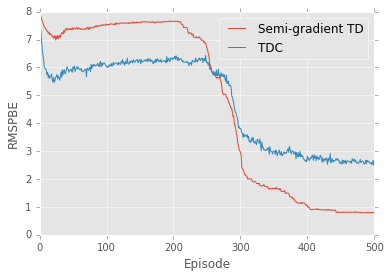

In [30]:
%matplotlib inline
RUN = 100
numOfTilings = 8
# best parameters for Semi Gradient TD - alpha = 0.4
SemigradientTD_err = []
for i in range(RUN):
    SemigradientTD(ValueFunction(0.05, numOfTilings), SemigradientTD_err)

# best parameters for TDC: apha = 0.05, beta=0.1
TDC_err = []
for i in range(RUN):
    TDC(ValueFunction(0.05, numOfTilings), TDC_err, 0.1/numOfTilings)

plt.plot(np.mean(SemigradientTD_err, axis=0), label = 'Semi-gradient TD')
plt.plot(np.mean(TDC_err, axis=0), label = 'TDC')
plt.xlabel('Episode')
plt.ylabel('RMSPBE')
plt.legend(loc='best')
plt.show()